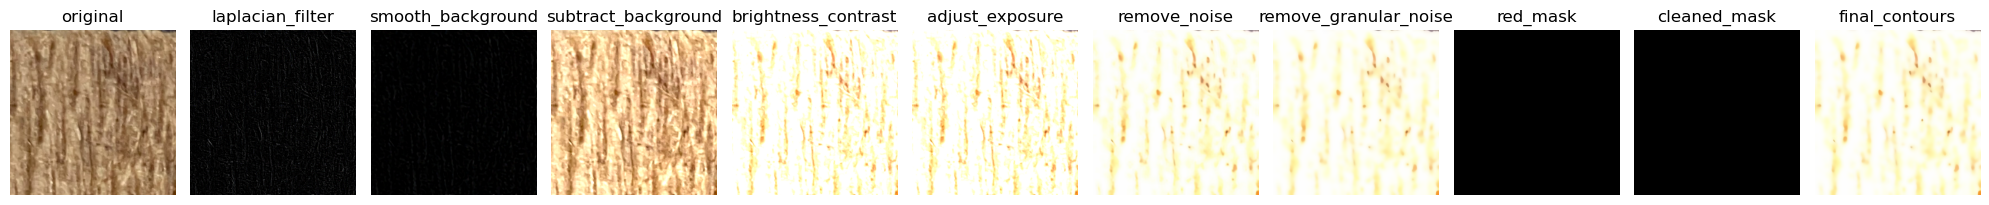

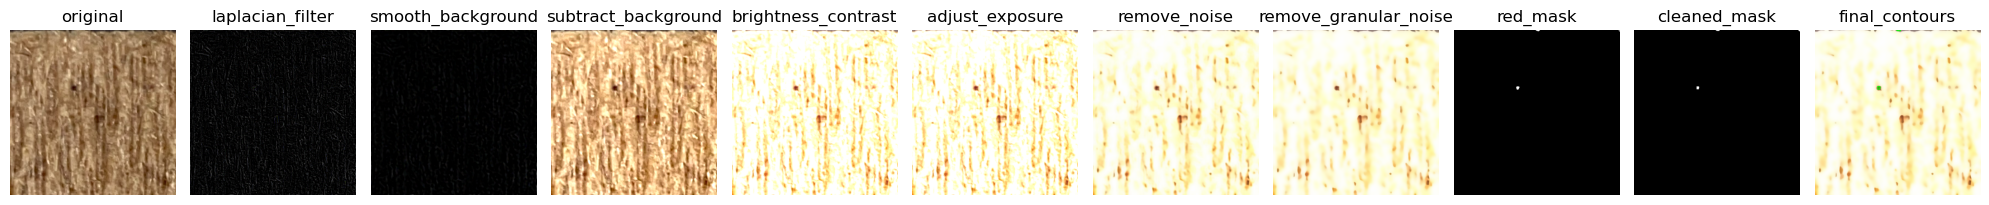

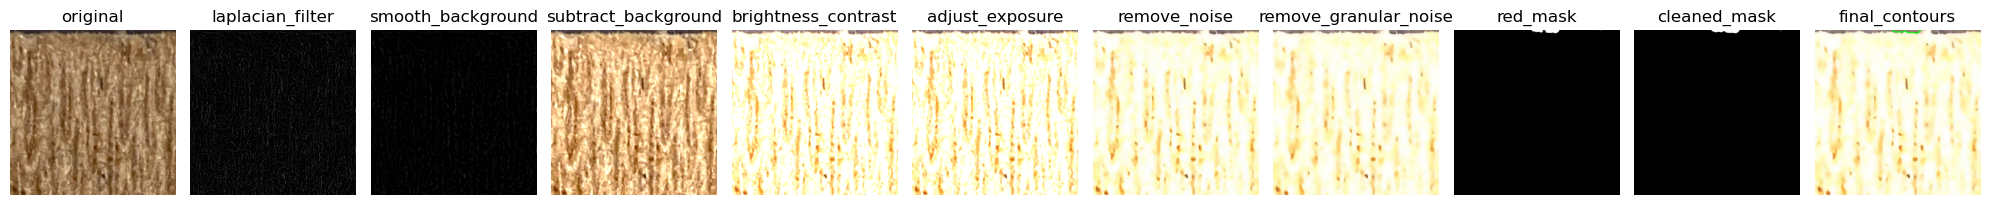

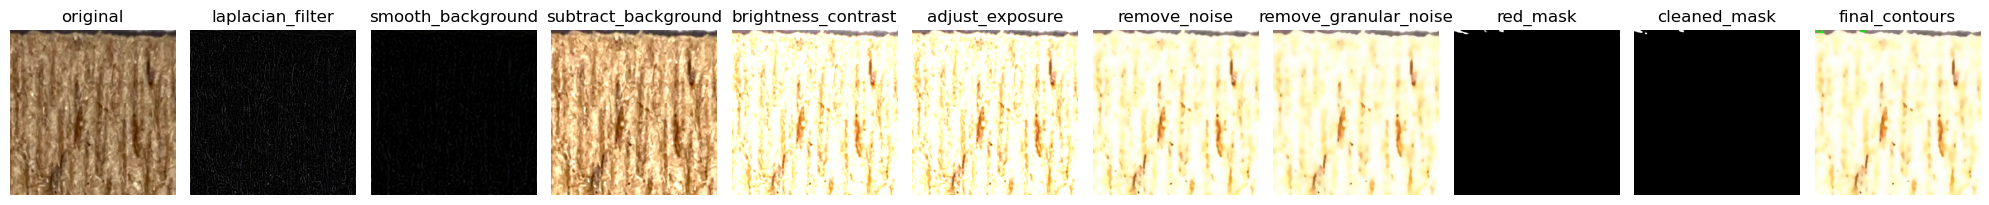

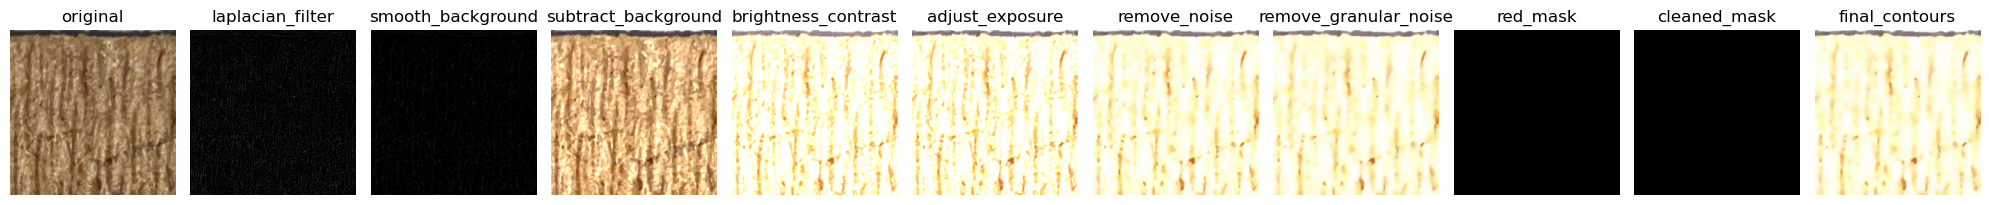

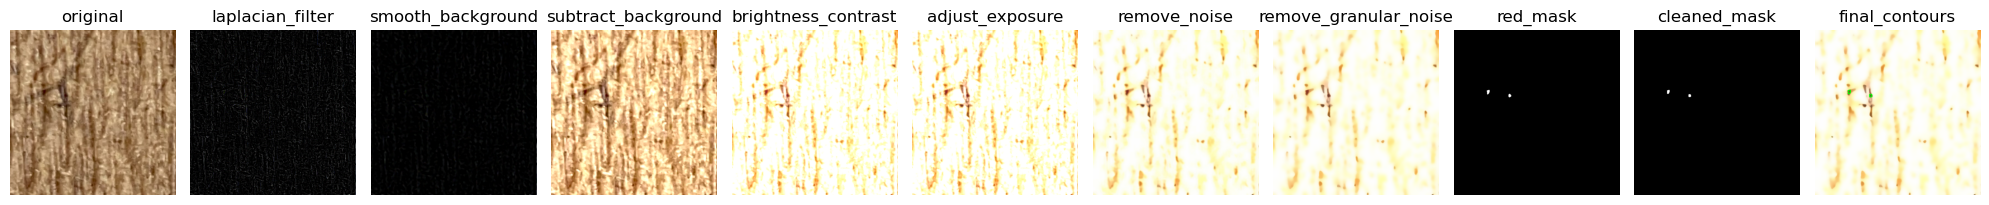

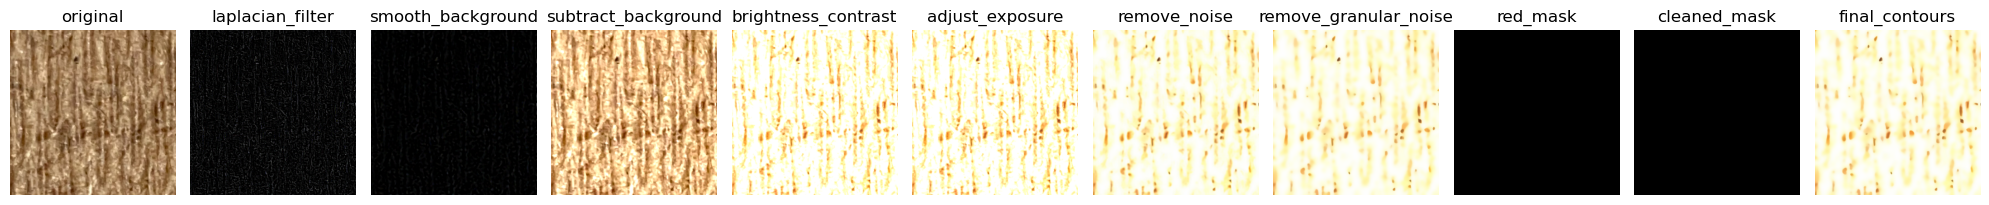

KeyboardInterrupt: 

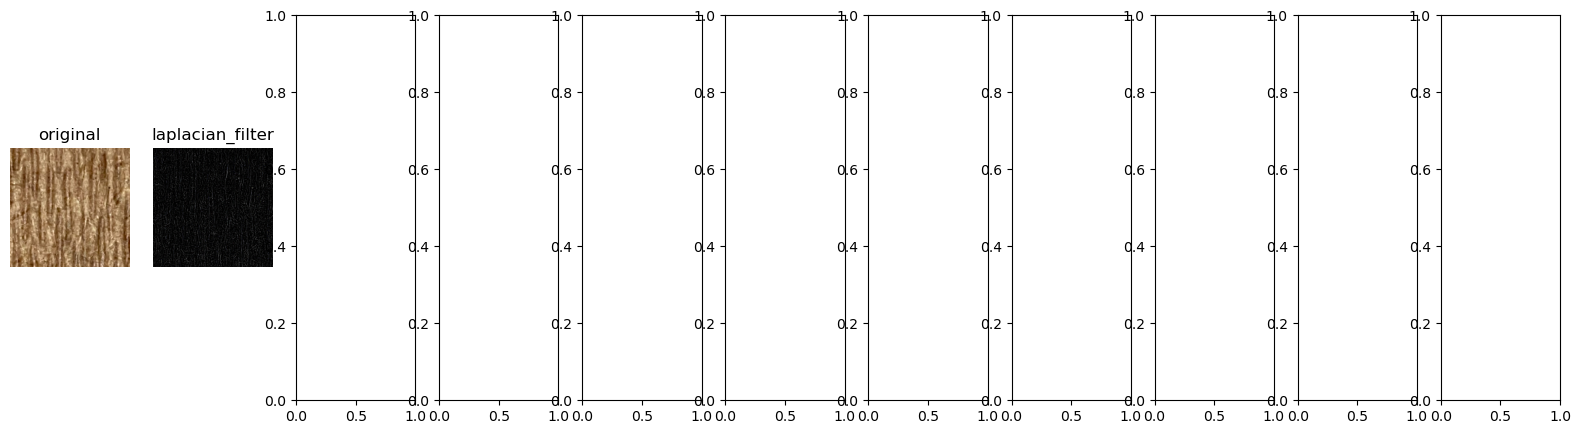

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

SQUARE_SIZE = 512

# Classe que realiza o processamento de cada quadrado
class SquareProcessor:
    def __init__(self, square):
        self.square = square
        self.stages = {'original': square.copy()}  # Dicionário para armazenar as etapas de processamento

    def adjust_exposure(self):
        """Ajuste de exposição usando CLAHE no canal de luminância da imagem."""
        hsv = cv2.cvtColor(self.square, cv2.COLOR_BGR2HSV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        hsv[:, :, 2] = clahe.apply(hsv[:, :, 2])
        self.square = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        self.stages['adjust_exposure'] = self.square.copy()

    def increase_brightness_contrast(self, alpha=1.5, beta=40):
        """Ajusta o brilho e contraste da imagem."""
        self.square = cv2.convertScaleAbs(self.square, alpha=alpha, beta=beta)
        self.stages['brightness_contrast'] = self.square.copy()

    def remove_noise(self):
        """Remove ruído da imagem usando a técnica Non-Local Means."""
        self.square = cv2.fastNlMeansDenoisingColored(self.square, None, 10, 10, 7, 21)
        self.stages['remove_noise'] = self.square.copy()

    def laplacian_filter(self):
        """Aplica filtro Laplaciano para realçar bordas."""
        self.square = cv2.Laplacian(self.square, cv2.CV_8U, ksize=3)
        self.stages['laplacian_filter'] = self.square.copy()

    def remove_granular_noise(self):
        """Remove ruído granular usando filtro bilateral."""
        self.square = cv2.bilateralFilter(self.square, 15, 75, 75)
        self.stages['remove_granular_noise'] = self.square.copy()

    def smooth_background(self, kernel_size=7):
        """Suaviza a imagem para remover texturas usando blur mediano."""
        self.square = cv2.medianBlur(self.square, kernel_size)
        self.stages['smooth_background'] = self.square.copy()

    def subtract_background(self, original_image):
        """Subtrai a imagem suavizada da original para destacar os objetos."""
        self.square = cv2.addWeighted(original_image, 1.5, self.square, -0.5, 0)
        self.stages['subtract_background'] = self.square.copy()

    def detect_red_objects_hsv(self):
        """Detecta objetos vermelhos na imagem utilizando o espaço HSV."""
        hsv_image = cv2.cvtColor(self.square, cv2.COLOR_BGR2HSV)
        
        # Intervalos de cor vermelha ajustados
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])

        mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        self.mask = cv2.bitwise_or(mask1, mask2)
        self.stages['red_mask'] = self.mask.copy()

    def clean_mask(self):
        """Aplica morfologia para limpar a máscara."""
        kernel = np.ones((5, 5), np.uint8)
        self.mask = cv2.morphologyEx(self.mask, cv2.MORPH_CLOSE, kernel)
        self.mask = cv2.morphologyEx(self.mask, cv2.MORPH_OPEN, kernel)
        self.stages['cleaned_mask'] = self.mask.copy()

    def count_objects(self):
        """Conta os objetos vermelhos no quadrado usando a máscara limpa."""
        contours, _ = cv2.findContours(self.mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos por área para evitar ruído
        min_area = 50   # Tamanho mínimo para ser considerado um ovo
        max_area = 2000  # Tamanho máximo para eliminar contornos irrelevantes
        filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]

        # Desenhar os contornos detectados na imagem original
        contour_img = self.square.copy()
        cv2.drawContours(contour_img, filtered_contours, -1, (0, 255, 0), 2)
        self.stages['final_contours'] = contour_img

        return len(filtered_contours)

    def process(self):
        """Executa todo o pipeline de processamento de imagem para o quadrado."""
        original_image = self.square.copy()
        
        # 5. Aplicar filtro Laplaciano para detecção de bordas
        self.laplacian_filter()
        
        # 6. Suavização do fundo
        self.smooth_background()
        
         # 7. Subtrair o fundo suavizado da imagem original
        self.subtract_background(original_image)

        # 2. Ajuste de brilho e contraste
        self.increase_brightness_contrast()
        
        # 1. Ajuste de exposição
        self.adjust_exposure()
       
       
        # 3. Remoção de ruído
        self.remove_noise()

        # 4. Remoção de ruído granular
        self.remove_granular_noise()

        # 8. Detectar objetos vermelhos na imagem
        self.detect_red_objects_hsv()

        # 9. Limpar a máscara com morfologia
        self.clean_mask()

        # 10. Contar objetos vermelhos
        return self.count_objects()

    def plot_stages(self):
        """Exibe todas as etapas do processamento de imagem."""
        stages = self.stages
        n_stages = len(stages)

        fig, axes = plt.subplots(1, n_stages, figsize=(20, 5))
        for idx, (stage_name, image) in enumerate(stages.items()):
            if len(image.shape) == 3:  # Se for uma imagem colorida
                axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            else:  # Se for uma imagem de máscara (grayscale)
                axes[idx].imshow(image, cmap='gray')
            axes[idx].set_title(stage_name)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

# Classe responsável por processar a imagem inteira
class ImageProcessor:
    def __init__(self, image_path, square_size=SQUARE_SIZE):
        self.image_path = image_path
        self.square_size = square_size
        self.contoured_squares = []

    def resize_to_fit_grid(self, image):
        """Redimensiona a imagem para que suas dimensões sejam múltiplos exatos do tamanho dos quadrados."""
        img_height, img_width, _ = image.shape

        # Calcular o novo tamanho que é múltiplo do tamanho do quadrado
        new_height = (img_height // self.square_size) * self.square_size
        new_width = (img_width // self.square_size) * self.square_size

        # Redimensionar a imagem
        resized_image = cv2.resize(image, (new_width, new_height))

        return resized_image

    def divide_and_process_image(self):
        """Divide a imagem redimensionada em quadrados e processa cada um."""
        image = cv2.imread(self.image_path)
        resized_image = self.resize_to_fit_grid(image)
        img_height, img_width, _ = resized_image.shape

        # Dividir a imagem em quadrados de tamanho square_size
        total_objects = 0
        for y in range(0, img_height, self.square_size):
            for x in range(0, img_width, self.square_size):
                # Extrair o quadrado da imagem redimensionada
                square = resized_image[y:y + self.square_size, x:x + self.square_size]

                # Processar o quadrado
                square_processor = SquareProcessor(square)
                objects_in_square = square_processor.process()

                # Armazenar quadrado com contornos desenhados
                total_objects += objects_in_square
                self.contoured_squares.append(square_processor.stages['final_contours'])

                # Exibir as etapas do processamento para cada quadrado
                square_processor.plot_stages()

        return total_objects, img_height, img_width

    def reconstruct_image(self, img_height, img_width):
        """Reconstrói a imagem a partir dos quadrados processados."""
        reconstructed_image = np.zeros((img_height, img_width, 3), dtype=np.uint8)
        count = 0
        for y in range(0, img_height, self.square_size):
            for x in range(0, img_width, self.square_size):
                reconstructed_image[y:y + self.square_size, x:x + self.square_size] = self.contoured_squares[count]
                count += 1

        return reconstructed_image

# Execução do código
# Definir caminho para a imagem
image_path = '/media/williancaddd/CODES/fiotec/AETrampa/Fotos/10__1ovos.jpg'

# Processar imagem e contar objetos
image_processor = ImageProcessor(image_path)
total_objects, img_height, img_width = image_processor.divide_and_process_image()
print(f"Total de objetos vermelhos na imagem: {total_objects}")

# Reconstruir imagem processada
reconstructed_image = image_processor.reconstruct_image(img_height, img_width)

# Mostrar imagem original e reconstruída
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
original_image = cv2.imread(image_path)
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Imagem Original')

axes[1].imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Imagem Reconstruída')

plt.show()
